# Convolutional Autoencoder for Noisy Images

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\snettani\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


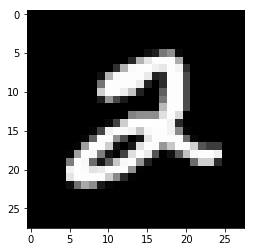

In [3]:
img = mnist.train.images[5]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

# Network Architecture
The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

## What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers aren't. Usually, you'll see transposed convolution layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, tf.nn.conv2d_transpose.

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In this Distill article from Augustus Odena, et al, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with tf.image.resize_images, followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena et al claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in tf.image.resize_images or use tf.image.resize_nearest_neighbor. For convolutional layers, use tf.layers.conv2d. For example, you would write conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu) for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use tf.layers.max_pooling2d.

In [18]:
inputs = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

#Encoder
conv1 = tf.layers.conv2d(inputs, 16, (3,3), padding='same', activation=tf.nn.relu) #28*28*16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same') #14*14*16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu) #14*14*8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same') #7*7*8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu) #7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same') #4x4x8

#Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7)) #7*7*8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu) #7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14)) #14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu) #14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28)) #28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu) #28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None) #28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')


loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

# Training

 We'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [19]:
sess = tf.Session()

In [20]:
epochs = 1
batch_size = 200
sess.run(tf.global_variables_initializer())

for e in range(epochs):
    for i in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1)) #convert the flattened images (784*1) to 28*28*1
        feed = {inputs: imgs, targets: imgs}
        batch_cost, _ = sess.run([cost, opt], feed_dict=feed)

        print("Epoch: {}/{}...".format(e+1, epochs), "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/1... Training loss: 0.6836
Epoch: 1/1... Training loss: 0.6786
Epoch: 1/1... Training loss: 0.6720
Epoch: 1/1... Training loss: 0.6640
Epoch: 1/1... Training loss: 0.6518
Epoch: 1/1... Training loss: 0.6402
Epoch: 1/1... Training loss: 0.6235
Epoch: 1/1... Training loss: 0.6053
Epoch: 1/1... Training loss: 0.5840
Epoch: 1/1... Training loss: 0.5652
Epoch: 1/1... Training loss: 0.5532
Epoch: 1/1... Training loss: 0.5390
Epoch: 1/1... Training loss: 0.5329
Epoch: 1/1... Training loss: 0.5304
Epoch: 1/1... Training loss: 0.5379
Epoch: 1/1... Training loss: 0.5416
Epoch: 1/1... Training loss: 0.5320
Epoch: 1/1... Training loss: 0.5295
Epoch: 1/1... Training loss: 0.5078
Epoch: 1/1... Training loss: 0.5052
Epoch: 1/1... Training loss: 0.5048
Epoch: 1/1... Training loss: 0.5033
Epoch: 1/1... Training loss: 0.4903
Epoch: 1/1... Training loss: 0.4856
Epoch: 1/1... Training loss: 0.4823
Epoch: 1/1... Training loss: 0.4789
Epoch: 1/1... Training loss: 0.4743
Epoch: 1/1... Training loss:

Epoch: 1/1... Training loss: 0.1538
Epoch: 1/1... Training loss: 0.1589
Epoch: 1/1... Training loss: 0.1643
Epoch: 1/1... Training loss: 0.1574
Epoch: 1/1... Training loss: 0.1610
Epoch: 1/1... Training loss: 0.1534
Epoch: 1/1... Training loss: 0.1608
Epoch: 1/1... Training loss: 0.1559
Epoch: 1/1... Training loss: 0.1570
Epoch: 1/1... Training loss: 0.1547
Epoch: 1/1... Training loss: 0.1546
Epoch: 1/1... Training loss: 0.1557
Epoch: 1/1... Training loss: 0.1559
Epoch: 1/1... Training loss: 0.1559
Epoch: 1/1... Training loss: 0.1620
Epoch: 1/1... Training loss: 0.1530
Epoch: 1/1... Training loss: 0.1558
Epoch: 1/1... Training loss: 0.1581
Epoch: 1/1... Training loss: 0.1518
Epoch: 1/1... Training loss: 0.1505
Epoch: 1/1... Training loss: 0.1558
Epoch: 1/1... Training loss: 0.1511
Epoch: 1/1... Training loss: 0.1569
Epoch: 1/1... Training loss: 0.1576
Epoch: 1/1... Training loss: 0.1531
Epoch: 1/1... Training loss: 0.1550
Epoch: 1/1... Training loss: 0.1513
Epoch: 1/1... Training loss:

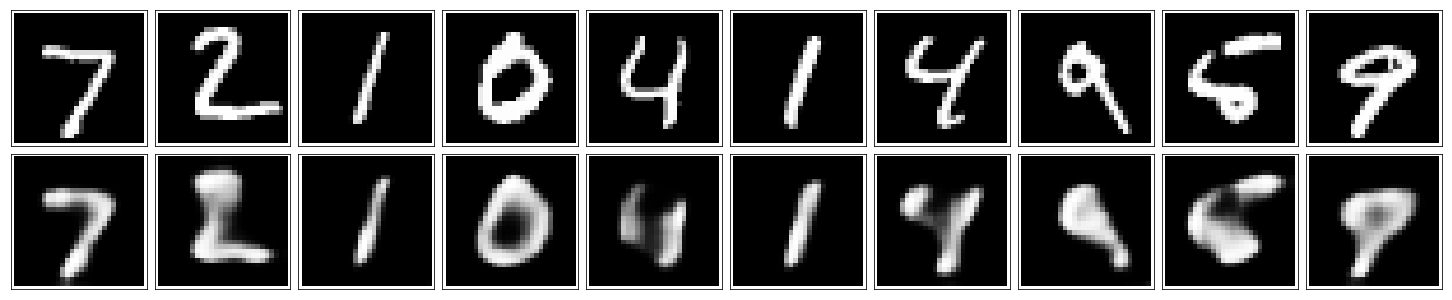

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [22]:
sess.close()

# Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder.

In [23]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [24]:
sess = tf.Session()

In [25]:
epochs = 20 #100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs, targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6952
Epoch: 1/20... Training loss: 0.6843
Epoch: 1/20... Training loss: 0.6676
Epoch: 1/20... Training loss: 0.6397
Epoch: 1/20... Training loss: 0.5992
Epoch: 1/20... Training loss: 0.5510
Epoch: 1/20... Training loss: 0.5067
Epoch: 1/20... Training loss: 0.4956
Epoch: 1/20... Training loss: 0.5123
Epoch: 1/20... Training loss: 0.5067
Epoch: 1/20... Training loss: 0.4801
Epoch: 1/20... Training loss: 0.4576
Epoch: 1/20... Training loss: 0.4507
Epoch: 1/20... Training loss: 0.4326
Epoch: 1/20... Training loss: 0.4223
Epoch: 1/20... Training loss: 0.4173
Epoch: 1/20... Training loss: 0.4128
Epoch: 1/20... Training loss: 0.3952
Epoch: 1/20... Training loss: 0.3720
Epoch: 1/20... Training loss: 0.3585
Epoch: 1/20... Training loss: 0.3361
Epoch: 1/20... Training loss: 0.3173
Epoch: 1/20... Training loss: 0.3108
Epoch: 1/20... Training loss: 0.3049
Epoch: 1/20... Training loss: 0.2959
Epoch: 1/20... Training loss: 0.2929
Epoch: 1/20... Training loss: 0.2783
E

Epoch: 1/20... Training loss: 0.1670
Epoch: 1/20... Training loss: 0.1654
Epoch: 1/20... Training loss: 0.1641
Epoch: 1/20... Training loss: 0.1646
Epoch: 1/20... Training loss: 0.1651
Epoch: 1/20... Training loss: 0.1660
Epoch: 1/20... Training loss: 0.1640
Epoch: 1/20... Training loss: 0.1616
Epoch: 1/20... Training loss: 0.1594
Epoch: 1/20... Training loss: 0.1684
Epoch: 1/20... Training loss: 0.1653
Epoch: 1/20... Training loss: 0.1652
Epoch: 1/20... Training loss: 0.1664
Epoch: 1/20... Training loss: 0.1650
Epoch: 1/20... Training loss: 0.1672
Epoch: 1/20... Training loss: 0.1644
Epoch: 1/20... Training loss: 0.1647
Epoch: 1/20... Training loss: 0.1587
Epoch: 1/20... Training loss: 0.1608
Epoch: 1/20... Training loss: 0.1665
Epoch: 1/20... Training loss: 0.1620
Epoch: 1/20... Training loss: 0.1584
Epoch: 1/20... Training loss: 0.1682
Epoch: 1/20... Training loss: 0.1676
Epoch: 1/20... Training loss: 0.1644
Epoch: 1/20... Training loss: 0.1667
Epoch: 1/20... Training loss: 0.1684
E

Epoch: 2/20... Training loss: 0.1478
Epoch: 2/20... Training loss: 0.1438
Epoch: 2/20... Training loss: 0.1456
Epoch: 2/20... Training loss: 0.1385
Epoch: 2/20... Training loss: 0.1396
Epoch: 2/20... Training loss: 0.1448
Epoch: 2/20... Training loss: 0.1402
Epoch: 2/20... Training loss: 0.1450
Epoch: 2/20... Training loss: 0.1424
Epoch: 2/20... Training loss: 0.1445
Epoch: 2/20... Training loss: 0.1417
Epoch: 2/20... Training loss: 0.1444
Epoch: 2/20... Training loss: 0.1438
Epoch: 2/20... Training loss: 0.1436
Epoch: 2/20... Training loss: 0.1415
Epoch: 2/20... Training loss: 0.1420
Epoch: 2/20... Training loss: 0.1387
Epoch: 2/20... Training loss: 0.1442
Epoch: 2/20... Training loss: 0.1430
Epoch: 2/20... Training loss: 0.1407
Epoch: 2/20... Training loss: 0.1392
Epoch: 2/20... Training loss: 0.1426
Epoch: 2/20... Training loss: 0.1404
Epoch: 2/20... Training loss: 0.1454
Epoch: 2/20... Training loss: 0.1366
Epoch: 2/20... Training loss: 0.1433
Epoch: 2/20... Training loss: 0.1384
E

Epoch: 3/20... Training loss: 0.1340
Epoch: 3/20... Training loss: 0.1331
Epoch: 3/20... Training loss: 0.1298
Epoch: 3/20... Training loss: 0.1368
Epoch: 3/20... Training loss: 0.1352
Epoch: 3/20... Training loss: 0.1318
Epoch: 3/20... Training loss: 0.1296
Epoch: 3/20... Training loss: 0.1315
Epoch: 3/20... Training loss: 0.1320
Epoch: 3/20... Training loss: 0.1302
Epoch: 3/20... Training loss: 0.1328
Epoch: 3/20... Training loss: 0.1304
Epoch: 3/20... Training loss: 0.1287
Epoch: 3/20... Training loss: 0.1326
Epoch: 3/20... Training loss: 0.1321
Epoch: 3/20... Training loss: 0.1329
Epoch: 3/20... Training loss: 0.1322
Epoch: 3/20... Training loss: 0.1311
Epoch: 3/20... Training loss: 0.1302
Epoch: 3/20... Training loss: 0.1335
Epoch: 3/20... Training loss: 0.1354
Epoch: 3/20... Training loss: 0.1300
Epoch: 3/20... Training loss: 0.1338
Epoch: 3/20... Training loss: 0.1314
Epoch: 3/20... Training loss: 0.1292
Epoch: 3/20... Training loss: 0.1325
Epoch: 3/20... Training loss: 0.1335
E

Epoch: 3/20... Training loss: 0.1267
Epoch: 3/20... Training loss: 0.1288
Epoch: 3/20... Training loss: 0.1280
Epoch: 3/20... Training loss: 0.1280
Epoch: 3/20... Training loss: 0.1271
Epoch: 3/20... Training loss: 0.1300
Epoch: 3/20... Training loss: 0.1305
Epoch: 3/20... Training loss: 0.1219
Epoch: 3/20... Training loss: 0.1268
Epoch: 3/20... Training loss: 0.1249
Epoch: 3/20... Training loss: 0.1296
Epoch: 3/20... Training loss: 0.1248
Epoch: 4/20... Training loss: 0.1271
Epoch: 4/20... Training loss: 0.1284
Epoch: 4/20... Training loss: 0.1258
Epoch: 4/20... Training loss: 0.1312
Epoch: 4/20... Training loss: 0.1276
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1293
Epoch: 4/20... Training loss: 0.1268
Epoch: 4/20... Training loss: 0.1253
Epoch: 4/20... Training loss: 0.1243
Epoch: 4/20... Training loss: 0.1302
Epoch: 4/20... Training loss: 0.1236
Epoch: 4/20... Training loss: 0.1260
Epoch: 4/20... Training loss: 0.1283
Epoch: 4/20... Training loss: 0.1264
E

KeyboardInterrupt: 

# Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

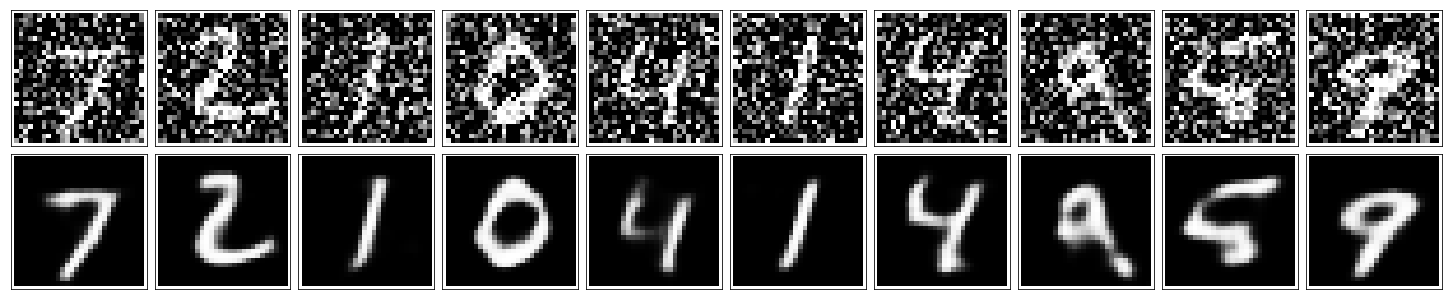

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]

#Add noise factor to the test images
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

In [27]:
sess.close()